In [1]:
import os
import math
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as tm
import torchvision.transforms.functional as tf
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torch.utils.data import DataLoader
from PIL import Image
from tqdm import tqdm
import transformers
%matplotlib inline
sys.path.append('../code')
sys.path.append('../../nn_tools/')

In [2]:
from core.data_utils import read_dcms, get_spacing, read_annotation, SPINAL_DISC_ID, SPINAL_VERTEBRA_ID, rotate_point
from core.visilization import visilize_annotation, visilize_distmap
from core.key_point import KeyPointAcc, KeyPointDataLoader, KeyPointModel, NullLoss
from core.key_point import KeyPointBCELossV2, SpinalModel, KeyPointModelV2, KeyPointBCELoss
from nn_tools import torch_utils

In [3]:
train_images, train_metainfos = read_dcms('../data/lumbar_train150/')
valid_images, valid_metainfos = read_dcms('../data/train/')

train_spacings = get_spacing(train_metainfos)
valid_spacings = get_spacing(valid_metainfos)

train_annotation = read_annotation('../data/lumbar_train150_annotation.json')
valid_annotation = read_annotation('../data/lumbar_train51_annotation.json')

100%|##########| 2826/2826 [00:05<00:00, 537.12it/s]


1.3.6.1.4.1.28173.1.0.1.1072190 
 1.3.6.1.4.1.28173.1.0.1.1.34320200531251 
 1.3.6.1.4.1.28173.1.0.1.1.34320200531251.376867.5 
 {'coord': [297, 228], 'tag': {'disc': '', 'identification': 'L1-L2', 'vertebra': ''}, 'zIndex': 5}
1.3.6.1.4.1.43960.1.1.10363147.60120337.80961 
 1.3.6.1.4.1.43960.1.1.10363147.60120337.80961.124281.2.3 
 1.3.6.1.4.1.43960.1.1.10363147.60120337.80961.124281.2.3.5 
 {'coord': [204, 121], 'tag': {'disc': '', 'identification': 'L1-L2', 'vertebra': ''}, 'zIndex': 4}
{'T11-T12': 1}


In [4]:
# all_pixels = [tf.to_tensor(image).flatten() for image in train_images.values()]
# all_pixels = torch.cat(all_pixels, dim=0)
# torch.save(all_pixels, 'all_pixels')

In [5]:
# all_pixels = torch.load('all_pixels')
# all_pixels = torch.cat([-all_pixels, all_pixels], dim=0)
# all_pixels.std()

In [6]:
train_pk_dataloader = KeyPointDataLoader(
    train_images, train_spacings, train_annotation, batch_size=8, num_workers=4,
    prob_rotate=1, max_angel=180, num_rep=100, prob_reverse=0, size=[512, 512],
    pin_memory=False
)
valid_pk_dataloader = KeyPointDataLoader(
    valid_images, valid_spacings, valid_annotation, batch_size=1, num_workers=4,
    prob_rotate=0, max_angel=45, num_rep=40, prob_reverse=0, size=[512, 512],
    pin_memory=False
)
generator = iter(valid_pk_dataloader)

100%|##########| 51/51 [00:00<00:00, 30813.82it/s]


In [7]:
# batch = next(generator)
# visilize_distmap(batch[0][0][0], batch[1][0][0])

In [8]:
kp_model = torch.load('../models/size512_rotate1_180_AdamW_1e-5.kp_model', map_location='cuda:0')

# backbone = resnet_fpn_backbone('resnet50', True)
# spinal_model = SpinalModel(train_images, train_annotation,
#                            num_candidates=128, num_selected_templates=8,
#                            max_translation=0.05, scale_range=[0.9, 1.1], max_angel=10)
# kp_model = KeyPointModel(backbone, len(SPINAL_DISC_ID)+len(SPINAL_VERTEBRA_ID),
#                          pixel_mean=torch.tensor(0.5), pixel_std=torch.tensor(1),
#                          loss=KeyPointBCELossV2(lamb=1), spinal_model=spinal_model).cuda(0)

# kp_model = torch.nn.DataParallel(kp_model, device_ids=[0, 1])

In [9]:
# model_name = '../models/1592671248.2164028/93750.checkpoint'
# temp = torch.load(model_name)
# kp_model.load_state_dict(temp.state_dict())
# torch.save(kp_model, model_name)
# del temp

In [10]:
with torch.no_grad():
#     batch = next(generator)
#     kp_model.train()
#     loss = kp_model(*batch[0])
    print(torch_utils.evaluate(kp_model, valid_pk_dataloader, [KeyPointAcc()]))

100%|##########| 2040/2040 [00:41<00:00, 48.99it/s]

[('KeyPointAcc', tensor(0.8808))]


In [11]:
# optimizer = transformers.AdamW(pos_model.parameters(), lr=0.001, correct_bias=False)
optimizer = torch.optim.AdamW(kp_model.parameters(), lr=1e-5)
max_step = 50*len(train_pk_dataloader)
# num_warm_up = len(train_pk_dataloader)
# scheduler = transformers.get_cosine_schedule_with_warmup(optimizer, num_warm_up, max_step)
result = torch_utils.fit(
    kp_model,
    train_pk_dataloader,
    valid_pk_dataloader,
    optimizer,
    max_step,
    NullLoss(),
    [KeyPointAcc()],
    is_higher_better=True,
    evaluate_per_steps=len(train_pk_dataloader),
#     scheduler=scheduler,
    checkpoint_dir='../models',
#     early_stopping=5*len(train_pk_dataloader),
)

using NullLoss as training loss, using KeyPointAcc(higher is better) as early stopping metric


100%|##########| 2040/2040 [01:43<00:00, 19.63it/s]


step 1875 train NullLoss: 0.1211942657828331; valid KeyPointAcc: 0.5594027042388916, 


100%|##########| 2040/2040 [01:44<00:00, 19.58it/s]


step 3750 train NullLoss: 0.04531325027346611; valid KeyPointAcc: 0.7447415590286255, 


100%|##########| 2040/2040 [01:44<00:00, 19.61it/s]


step 5625 train NullLoss: 0.028970662504434586; valid KeyPointAcc: 0.7452763319015503, 


100%|##########| 2040/2040 [01:44<00:00, 19.61it/s]


step 7500 train NullLoss: 0.024631071835756302; valid KeyPointAcc: 0.7705880999565125, 


100%|##########| 2040/2040 [01:44<00:00, 19.58it/s]


step 9375 train NullLoss: 0.023859407752752304; valid KeyPointAcc: 0.7843136787414551, 


100%|##########| 2040/2040 [01:44<00:00, 19.57it/s]


step 11250 train NullLoss: 0.019207648932933807; valid KeyPointAcc: 0.7747769951820374, 


100%|##########| 2040/2040 [01:44<00:00, 19.58it/s]


step 13125 train NullLoss: 0.021145574748516083; valid KeyPointAcc: 0.7817290425300598, 


100%|##########| 2040/2040 [01:44<00:00, 19.60it/s]


step 15000 train NullLoss: 0.01818457618355751; valid KeyPointAcc: 0.7863636016845703, 


100%|##########| 2040/2040 [01:44<00:00, 19.53it/s]


step 16875 train NullLoss: 0.016988171264529228; valid KeyPointAcc: 0.7694740295410156, 


100%|##########| 2040/2040 [01:44<00:00, 19.52it/s]


step 18750 train NullLoss: 0.020730920135974884; valid KeyPointAcc: 0.7518271207809448, 


100%|##########| 2040/2040 [01:44<00:00, 19.54it/s]


step 20625 train NullLoss: 0.01640099100768566; valid KeyPointAcc: 0.7534313201904297, 


100%|##########| 2040/2040 [01:44<00:00, 19.53it/s]


step 22500 train NullLoss: 0.018362533301115036; valid KeyPointAcc: 0.7690730690956116, 


100%|##########| 2040/2040 [01:44<00:00, 19.49it/s]


step 24375 train NullLoss: 0.016066012904047966; valid KeyPointAcc: 0.7701426148414612, 


100%|##########| 2040/2040 [01:44<00:00, 19.54it/s]


step 26250 train NullLoss: 0.0176706500351429; valid KeyPointAcc: 0.7032085061073303, 


100%|##########| 2040/2040 [01:44<00:00, 19.51it/s]


step 28125 train NullLoss: 0.01718253456056118; valid KeyPointAcc: 0.7502673864364624, 


100%|##########| 2040/2040 [01:44<00:00, 19.49it/s]


step 30000 train NullLoss: 0.01558044645935297; valid KeyPointAcc: 0.7561052441596985, 


100%|##########| 2040/2040 [01:44<00:00, 19.48it/s]


step 31875 train NullLoss: 0.016768358647823334; valid KeyPointAcc: 0.7984849214553833, 


100%|##########| 2040/2040 [01:44<00:00, 19.52it/s]


step 33750 train NullLoss: 0.01570362225174904; valid KeyPointAcc: 0.7472817301750183, 


100%|##########| 2040/2040 [01:44<00:00, 19.50it/s]


step 35625 train NullLoss: 0.01507424283772707; valid KeyPointAcc: 0.7418894171714783, 


100%|##########| 2040/2040 [01:44<00:00, 19.49it/s]


step 37500 train NullLoss: 0.016153370961546898; valid KeyPointAcc: 0.751158595085144, 


100%|##########| 2040/2040 [01:44<00:00, 19.49it/s]


step 39375 train NullLoss: 0.014875574968755245; valid KeyPointAcc: 0.7476380467414856, 


100%|##########| 2040/2040 [01:44<00:00, 19.43it/s]


step 41250 train NullLoss: 0.015181156806647778; valid KeyPointAcc: 0.7657755613327026, 


100%|##########| 2040/2040 [01:44<00:00, 19.45it/s]


step 43125 train NullLoss: 0.014925073832273483; valid KeyPointAcc: 0.7404189109802246, 


100%|##########| 2040/2040 [01:44<00:00, 19.47it/s]


step 45000 train NullLoss: 0.014993389137089252; valid KeyPointAcc: 0.7745544910430908, 


100%|##########| 2040/2040 [01:44<00:00, 19.45it/s]


step 46875 train NullLoss: 0.015588284470140934; valid KeyPointAcc: 0.7495543360710144, 


100%|##########| 2040/2040 [01:44<00:00, 19.47it/s]


step 48750 train NullLoss: 0.01444963552057743; valid KeyPointAcc: 0.7466129064559937, 


100%|##########| 2040/2040 [01:44<00:00, 19.43it/s]


step 50625 train NullLoss: 0.014353496953845024; valid KeyPointAcc: 0.7429145574569702, 


100%|##########| 2040/2040 [01:45<00:00, 19.37it/s]


step 52500 train NullLoss: 0.015514018014073372; valid KeyPointAcc: 0.7516042590141296, 


100%|##########| 2040/2040 [01:45<00:00, 19.40it/s]


step 54375 train NullLoss: 0.014310107566416264; valid KeyPointAcc: 0.7564615607261658, 


100%|##########| 2040/2040 [01:45<00:00, 19.41it/s]


step 56250 train NullLoss: 0.015412145294249058; valid KeyPointAcc: 0.7850713133811951, 


100%|##########| 2040/2040 [01:45<00:00, 19.43it/s]


step 58125 train NullLoss: 0.014578425325453281; valid KeyPointAcc: 0.7625668048858643, 


100%|##########| 2040/2040 [01:45<00:00, 19.40it/s]


step 60000 train NullLoss: 0.014140846207737923; valid KeyPointAcc: 0.7494654059410095, 


100%|##########| 2040/2040 [01:44<00:00, 19.43it/s]


step 61875 train NullLoss: 0.014066594652831554; valid KeyPointAcc: 0.7529857158660889, 


100%|##########| 2040/2040 [01:45<00:00, 19.42it/s]


step 63750 train NullLoss: 0.015263430774211884; valid KeyPointAcc: 0.7604722380638123, 


100%|##########| 2040/2040 [01:45<00:00, 19.38it/s]


step 65625 train NullLoss: 0.01401363592594862; valid KeyPointAcc: 0.7686274647712708, 


100%|##########| 2040/2040 [01:45<00:00, 19.40it/s]


step 67500 train NullLoss: 0.014865649864077568; valid KeyPointAcc: 0.7889928817749023, 


100%|##########| 2040/2040 [01:45<00:00, 19.42it/s]


step 69375 train NullLoss: 0.014212744310498238; valid KeyPointAcc: 0.7704991102218628, 


100%|##########| 2040/2040 [01:45<00:00, 19.37it/s]


step 71250 train NullLoss: 0.013886790722608566; valid KeyPointAcc: 0.7769160270690918, 


100%|##########| 2040/2040 [01:45<00:00, 19.39it/s]


step 73125 train NullLoss: 0.013836347497999668; valid KeyPointAcc: 0.7709000706672668, 


100%|##########| 2040/2040 [01:45<00:00, 19.36it/s]


step 75000 train NullLoss: 0.015537681058049202; valid KeyPointAcc: 0.7864526510238647, 


100%|##########| 2040/2040 [01:45<00:00, 19.34it/s]


step 76875 train NullLoss: 0.014053212478756905; valid KeyPointAcc: 0.7654631733894348, 


100%|##########| 2040/2040 [01:45<00:00, 19.38it/s]


step 78750 train NullLoss: 0.013778259046375751; valid KeyPointAcc: 0.7712119817733765, 


100%|##########| 2040/2040 [01:45<00:00, 19.41it/s]


step 80625 train NullLoss: 0.013715704903006554; valid KeyPointAcc: 0.7726827263832092, 


100%|##########| 2040/2040 [01:45<00:00, 19.35it/s]


step 82500 train NullLoss: 0.01368751935660839; valid KeyPointAcc: 0.7770944833755493, 


100%|##########| 2040/2040 [01:45<00:00, 19.32it/s]


step 84375 train NullLoss: 0.013646330684423447; valid KeyPointAcc: 0.7670232057571411, 


100%|##########| 2040/2040 [01:46<00:00, 19.23it/s]


step 86250 train NullLoss: 0.0135873444378376; valid KeyPointAcc: 0.7741977572441101, 


 46%|####5     | 860/1875 [03:30<04:08,  4.08it/s]


KeyboardInterrupt: 

In [12]:
# torch.save(kp_model, '../models/size512_rotate1_180_AdamW_1e-5.kp_model')

In [ ]:
# kp_model = torch.load('../models/resize_rotate_reverse.kp_model')
# test_pk_dataloader = KeyPointDataLoader(
#     valid_images, valid_spacings, valid_annotation, batch_size=1,
#     random_resize=True, prob_rotate=1, max_angel=45,
# )
# generator = iter(test_pk_dataloader)
# torch_utils.evaluate(kp_model, test_pk_dataloader, [KeyPointAcc()])

tensor(0.9091, device='cuda:0')


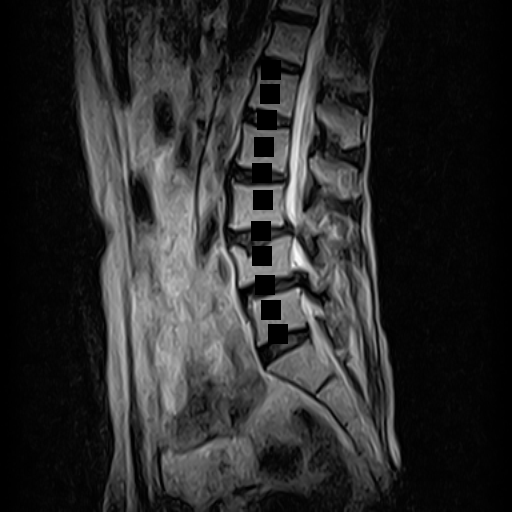

In [27]:
batch = next(generator)
with torch.no_grad():
    kp_model.eval()
    heatmaps = kp_model.cal_scores(batch[0][0]).sigmoid()
    preds = kp_model.spinal_model(heatmaps)
    print(KeyPointAcc()(preds, *batch[1]))
visilize_annotation(tf.to_pil_image(batch[0][0][0]), preds[0])

In [ ]:
kp_model.spinal_model.

In [ ]:
# tf.to_pil_image(1 / (batch[1][0][0, 7] / 8 * math.log(2)).exp())

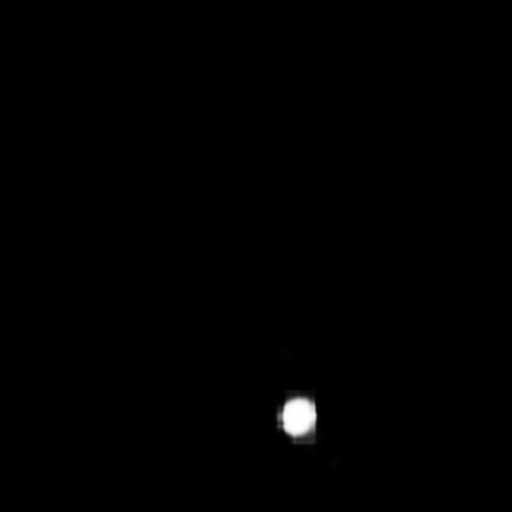

In [17]:
tf.to_pil_image(heatmaps[0, 10].cpu())